# Using plum

This notebook will help you use the classes in ``plum``. See the README

In [1]:
import dendropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plum.sim
import plum.util.data
import plum.models.ErrorModels
import plum.models.MarkovModels
import plum.training.likelihood
import plum.training.recall_precision

%matplotlib inline

## Specifying a model

PLVM models have two components, an error model and a continuous time Markov model (CTMC). You can specify the parameters of each of these by accessing the classes contained in ``plum.models.ErrorModels`` and ``plum.models.MarkovModels``, respectively

#### Specify the CTMC
So far, the class TwoState is the only available CTMC model, and describes a rate matrix

$$
\textbf{Q} =
\begin{pmatrix}
-\alpha&\alpha \\
\beta&-\beta
\end{pmatrix}
$$

where $\alpha$ and $\beta$ are the instantaneous rate parameters describing gains and losses of network edges, respectively. 

In [2]:
ctmc = plum.models.MarkovModels.TwoState(alpha=.01,beta=.1)

#### Setting free parameterse

The ``params`` attribute shows the relevant parameters of the model

In [3]:
ctmc.params

{'alpha': 0.01,
 'beta': 0.1,
 'mu': 0.11,
 'pi0': 0.9090909090909092,
 'pi1': 0.09090909090909083}

However, the only *free* parameters of this model are ``alpha`` and ``beta``, and hence they are the only ones we need to/can set when we specify the model. (To see how $\mu$, $\pi_0$, and $\pi_1$ are related to $\alpha$ and $\beta$, see the extended methods of the paper.)

The free parameters are held in the ``freeParams`` attribute.

In [4]:
ctmc.freeParams

['alpha', 'beta']

If you want to clamp one of the parameters during model fitting, you can do that by removing free parameters. Here's an example in text, but for now we'll keep all the parameters free

``ctmc.freeParams = ["alpha"]``

#### Specify the error model

We'll start with a simple Gaussian model of a 1-dimensional feature. Here, ``mean0`` corresponds to the expected mean of the data for negative interactions, i.e. where no edge is expected. ``sd0`` corresponds to the expected standard deviation of negative interactions, and ``mean1`` and ``sd1`` are the parameters for true interactions.

In [5]:
gauss = plum.models.ErrorModels.Gaussian(mean0=-.5, sd0=.5, mean1=.5, sd1=.5)

In [6]:
gauss.params

{'mean0': -0.5, 'mean1': 0.5, 'sd0': 0.5, 'sd1': 0.5}

#### Adding bounds

It may be a good idea to add bounds, especially to the error model. This will prevent the fitting algorithm from trying parameter values that are way out of wack and can help prevent over-fitting.

In [7]:
gauss.paramBounds = {"mean0":(-2,2), "sd0":(0,5)} # note that you don't have to set all of them

In [8]:
gauss.paramBounds

{'mean0': (-2, 2), 'mean1': (-inf, inf), 'sd0': (0, 5), 'sd1': (0.0, inf)}

### Reading and writing parameter files

Now that we have some starting parameter values, it's a good idea to write them to parameter files

In [9]:
plum.util.data.write_parameter_file(error_model=gauss, markov_model=ctmc, outfile="gaussian_test.param")

#### Param file format

The parameter files are important. Each component -- the error model and the Markov model -- has a field defined by '#'. The name of the error model and Markov model classes are in the "Name" field and the parameter values and bounds are in the "Params" and "Bounds" fields, each of which is semi-colon delimited. Note that if you are using the default bounds, that line will be blank when you write it, as in the Markov model component below

In [10]:
!cat gaussian_test.param

# Error Model
Name: Gaussian
Params: sd0=0.5;mean0=-0.5;mean1=0.5;sd1=0.5
Bounds: mean0=(-2, 2);mean1=(-np.inf, np.inf);sd0=(0, 5);sd1=(0.0, np.inf)

# Markov Model
Name: TwoState
Params: alpha=0.01;beta=0.1


#### You can also read parameter files, like so

In [11]:
em,mm = plum.util.data.get_models_from_file("gaussian_test.param")

print "Markov Model Parameters: {}".format(mm.params)
print "Error Model Parameters: {}".format(em.params)
print "Error Model Bounds: {}".format(em.paramBounds)

Markov Model Parameters: {'mu': 0.11, 'alpha': 0.01, 'beta': 0.1, 'pi0': 0.9090909090909092, 'pi1': 0.09090909090909083}
Error Model Parameters: {'mean0': -0.5, 'sd0': 0.5, 'mean1': 0.5, 'sd1': 0.5}
Error Model Bounds: {'mean0': (-2, 2), 'mean1': (-inf, inf), 'sd0': (0, 5), 'sd1': (0.0, inf)}


## Simulating data

Now we'll try simulating some data under our current model. To do so, we'll need a tree. I'll use the one from the paper

In [12]:
# note that we need to read in the internal node taxa
tree = dendropy.Tree.get_from_path("../testdata/bikont_tree.nhx",'newick',suppress_internal_node_taxa=False)
print tree.as_ascii_plot()

                       /-------------------------------------------------------------------------------------------------------------------------------------------- Sc
                       |                                                                                                                                               
                       |                                                                                             /---------------------------------------------- Xl
                       |                                                                     /-----------------------+                                                 
                       |                                                                     |                       |                      /----------------------- Mm
/----------------------+                                              /----------------------+                       \----------------------+                   

Now create a simulation class with the model we just read in to the variables ``em`` and ``mm``

In [13]:
## Note: TwoStateSim is currently the only class in plum.sim
gaussian_sim = plum.sim.TwoStateSim(tree=tree, markov_model=mm, error_model=em, nchars=100)

Run the simulation. You have to specify at least the node outfile which writes information about all the nodes. Optionally, you can specify a "tips" outfile, which has the same format as real data that you'll read in to fit the model.

In [14]:
%%capture

gaussian_sim(node_outfile="gaussian_sim_nodes.csv",
            tip_outfile="gaussian_sim_tips.csv",
            tip_data=True)

Let's look at the data

In [15]:
sim_nodes = pd.read_csv("gaussian_sim_nodes.csv")
sim_tips = pd.read_csv("gaussian_sim_tips.csv")

In [16]:
sim_nodes.head()

,site,node,state,switch,data
0,0,Sc,0,False,-0.845237
1,1,Sc,0,False,-0.788428
2,2,Sc,0,False,-0.290446
3,3,Sc,0,False,-0.203383
4,4,Sc,0,False,-0.462679


#### Tips file

When you create your own data files with real data, it should look like this, except the ``data`` column could be named anything and there can be multiple features. We'll look at an example below

In [17]:
sim_tips.head()

,ID1,ID2,species,data,state
0,0,0,Sc,-0.845237,0
1,1,1,Sc,-0.788428,0
2,2,2,Sc,-0.290446,0
3,3,3,Sc,-0.203383,0
4,4,4,Sc,-0.462679,0


Let us look at that which we have wrought. As expected, the mean of interactors is around 1, and non-interactors around -1, just we specified in the construction of the error model above. Also note that there are fewer interactors (state = 1) than non-interactors (state = 0). That's because we set ``alpha`` to be lower than ``beta`` above.

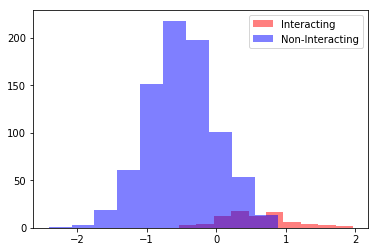

In [18]:
fig,ax = plt.subplots()

pos = sim_tips[sim_tips.state == 1]
neg = sim_tips[sim_tips.state == 0]

_ = pos.data.hist(ax=ax,color='red',alpha=.5,label="Interacting")
_ = neg.data.hist(ax=ax,color='blue',alpha=.5,label="Non-Interacting")
_ = ax.legend()

ax.grid(False)

## Fitting a model

First, we'll try fitting a model using likelihood using our simulated data

In [19]:
# Note that there are many other possible models for a single state. I haven't found very big performance differences.
start_em = plum.models.ErrorModels.Gaussian()
start_mm = plum.models.MarkovModels.TwoState()

In [20]:
print start_em.params

{'mean0': 0.0, 'sd0': 1.0, 'mean1': 0.0, 'sd1': 1.0}


In [21]:
print start_mm.params

{'mu': 2.0, 'alpha': 1.0, 'beta': 1.0, 'pi0': 0.5, 'pi1': 0.5}


In [22]:
like_model = plum.training.likelihood.simulated_annealing(error_model=start_em,
                                                          markov_model=start_mm,
                                                          tree=tree,data=sim_tips,
                                                          start_temp=1.0,
                                                          alpha=.5,
                                                          temp_steps=10,
                                                          mutation_sd=.3)

Parsing unsorted dataframe
Finished loading data
Initializing model
Finished initializing model


In [23]:
print "Starting log likelihood: {}".format(like_model.logL)

Starting log likelihood: -1046.40806747


In [24]:
like_model.fit()

Current temp: 0.5	Best score: -883.198123842	Accept rate at this T: 0.600000023842
Current temp: 0.25	Best score: -863.342613368	Accept rate at this T: 0.40000000596
Current temp: 0.125	Best score: -807.400366416	Accept rate at this T: 0.20000000298
Current temp: 0.0625	Best score: -782.690820143	Accept rate at this T: 0.40000000596
Current temp: 0.03125	Best score: -782.690820143	Accept rate at this T: 0.0
Current temp: 0.015625	Best score: -774.77916481	Accept rate at this T: 0.300000011921
Current temp: 0.0078125	Best score: -774.735785906	Accept rate at this T: 0.10000000149
Current temp: 0.00390625	Best score: -774.042438693	Accept rate at this T: 0.20000000298
Current temp: 0.001953125	Best score: -774.042438693	Accept rate at this T: 0.0
Current temp: 0.0009765625	Best score: -773.987365004	Accept rate at this T: 0.10000000149
Current temp: 0.00048828125	Best score: -772.133159699	Accept rate at this T: 0.10000000149
Current temp: 0.000244140625	Best score: -772.133159699	Accept

In [25]:
like_model.params

{'alpha': 0.666239395829176,
 'beta': 0.6056416154874873,
 'mean0': -0.1514964889597626,
 'mean1': -0.6078308418059257,
 'mu': 1.2718810113166632,
 'pi0': 0.4761778893613023,
 'pi1': 0.5238221106386978,
 'sd0': 0.6286254663419026,
 'sd1': 0.38530700804616136}

#### Fitting with recall-precision

In [26]:
## Above, we called simulated_annealing using our tree and sim_tips objects, but we can also load from a file, as here
rp_model = plum.training.recall_precision.simulated_annealing(error_model=start_em,
                                                          markov_model=start_mm,
                                                          tree='../testdata/bikont_tree.nhx',
                                                          data="gaussian_sim_tips.csv",
                                                          start_temp=1.0,
                                                          alpha=.5,
                                                          temp_steps=10,
                                                          mutation_sd=.3)

Loading dataframe
Parsing unsorted dataframe
Finished loading data
Initializing model
Finished initializing model


In [27]:
print "Starting Average Precision Score (APS): {}".format(rp_model.aps)

Starting Average Precision Score (APS): 0.09


In [28]:
rp_model.fit()

Current temp: 0.5	Best score: 0.710016092758	Accept rate at this T: 0.899999976158
Current temp: 0.25	Best score: 0.903727464479	Accept rate at this T: 0.699999988079
Current temp: 0.125	Best score: 0.903727464479	Accept rate at this T: 0.699999988079
Current temp: 0.0625	Best score: 0.903727464479	Accept rate at this T: 0.699999988079
Current temp: 0.03125	Best score: 0.903727464479	Accept rate at this T: 0.899999976158
Current temp: 0.015625	Best score: 0.903727464479	Accept rate at this T: 0.699999988079
Current temp: 0.0078125	Best score: 0.933436825274	Accept rate at this T: 0.699999988079
Current temp: 0.00390625	Best score: 0.952186784783	Accept rate at this T: 0.699999988079
Current temp: 0.001953125	Best score: 0.952186784783	Accept rate at this T: 0.300000011921
Current temp: 0.0009765625	Best score: 0.952186784783	Accept rate at this T: 0.5
Current temp: 0.00048828125	Best score: 0.952186784783	Accept rate at this T: 0.5
Current temp: 0.000244140625	Best score: 0.95218678478

In [29]:
rp_model.params

{'alpha': 0.06139583330455703,
 'beta': 0.37138088740980874,
 'mean0': -0.8558117115254644,
 'mean1': 1.2869676584665752,
 'mu': 0.4327767207143658,
 'pi0': 0.8581350835987351,
 'pi1': 0.14186491640126486,
 'sd0': 0.7341371346848083,
 'sd1': 2.2171994790851604}

#### Looking at the results

After fitting, the recall_precision module has some nice data structures we can populate to look at the results. One holds the precision-recall curve, and the other holds the predicted scores on the training data with false discovery rate thresholds. Both are pandas dataframes

In [30]:
rp_model_prc_df = rp_model.precision_recall_DF
rp_model_results_df = rp_model.results_DF

In [32]:
rp_model_prc_df.head()

,precision,recall
493,1.0,0.000000
492,1.0,0.012346
491,1.0,0.024691
490,1.0,0.037037
489,1.0,0.049383


In [33]:
rp_model_results_df.head()

,ID1,ID2,species,state,P_1,FDR
0,75,75,Hs,1,0.999541,0.0
1,47,47,Mm,1,0.998944,0.0
2,75,75,Dm,1,0.994446,0.0
3,75,75,Xl,1,0.988012,0.0
4,75,75,Ce,1,0.986971,0.0


#### Compare likelihood and recall_precision fitting

In [34]:
like_model.errorModelParams

{'mean0': -0.1514964889597626,
 'mean1': -0.6078308418059257,
 'sd0': 0.6286254663419026,
 'sd1': 0.38530700804616136}

In [35]:
like_em = plum.models.ErrorModels.Gaussian(**like_model.errorModelParams)
like_mm = plum.models.MarkovModels.TwoState(**like_model.markovModelParams)

In [36]:
like_rp = plum.training.recall_precision.plumRecallPrecision(error_model=like_em,
                                                             markov_model=like_mm,
                                                             tree=tree,
                                                             data=sim_tips)

Parsing unsorted dataframe
Finished loading data
Initializing model
Finished initializing model


In [37]:
like_model_prc_df = like_rp.precision_recall_DF
like_model_results_df = like_rp.results_DF

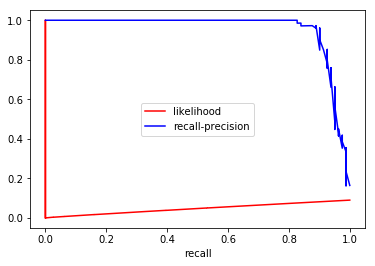

In [38]:
fig,ax = plt.subplots()

like_model_prc_df.plot(ax=ax,x="recall",y="precision",color="red",label="likelihood")
rp_model_prc_df.plot(ax=ax,x="recall",y="precision",color="blue",label="recall-precision")

ax.legend()

In this case, fitting by recall-precision (APS) was much better, but you can play around with the simulated data and you'll find that, as you increase the difference between mean0 and mean1, decrease the standard deviations, and decrease the class imbalance (by making alpha and beta more similar), likelihood will do better and better, sometimes outperforming APS fitting